In [37]:
import torch as torch
import cv2
import numpy as np
import matplotlib.cm as cm
# from kornia import make_matching_figure
from kornia.feature import LoFTR
import glob
import matplotlib.pyplot as plt


In [38]:

imagePaths = glob.glob(f'./mugOnCarpet/*.jpg')
print(imagePaths)

['./mugOnCarpet/PXL_20230713_184143425.jpg', './mugOnCarpet/PXL_20230713_184134651.jpg', './mugOnCarpet/PXL_20230713_184146390.jpg', './mugOnCarpet/PXL_20230713_184140374.jpg', './mugOnCarpet/PXL_20230713_184153119.jpg', './mugOnCarpet/PXL_20230713_184129417.jpg', './mugOnCarpet/PXL_20230713_184201937.jpg']


In [39]:
matcher = LoFTR(pretrained='indoor')
matcher = matcher.eval().cpu()

In [40]:


img0_raw = cv2.imread(imagePaths[6],  cv2.IMREAD_GRAYSCALE  ) 
img1_raw = cv2.imread(imagePaths[4], cv2.IMREAD_GRAYSCALE)
# print(img0_raw.shape)
newDim= (640,360)

img0_raw = cv2.resize(img0_raw, newDim)
img1_raw = cv2.resize(img1_raw, newDim)

# mask = np.ones((480, 640)).astype(np.int32)
# mask[0:50, 500:] = 0
# mask[430:480, :] = 0
# # img0_raw = np.multiply(img0_raw, mask)
# img1_raw = np.multiply(img1_raw, mask)

img0 = torch.from_numpy(img0_raw)[None][None].cpu() / 255.
img1 = torch.from_numpy(img1_raw)[None][None].cpu() / 255.
batch = {'image0': img0, 'image1': img1}

# Inference with LoFTR and get prediction
with torch.no_grad():
    correspondences = matcher(batch)
    print(correspondences.keys())
    mkpts0 = correspondences['keypoints0'].cpu().numpy()
    mkpts1 = correspondences['keypoints1'].cpu().numpy()
    mconf = correspondences['confidence'].cpu().numpy()

dict_keys(['keypoints0', 'keypoints1', 'confidence', 'batch_indexes'])


In [41]:
color = cm.jet(mconf, alpha=0.2)
# fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1)

In [42]:
# get top 200 matches
N = min(200, mconf.shape[0])
print(N)
idx = np.argpartition(mconf, -N)[-N:]
mkpts0b = mkpts0[idx]
mkpts1b = mkpts1[idx]
mconfb = mconf[idx]

color = cm.jet(mconfb, alpha=0.2)
# fig = make_matching_figure(img0_raw, img1_raw, mkpts0b, mkpts1b, color, mkpts0b, mkpts1b)

200


In [43]:
def drawLines(img, lines, pts):
    print(img.shape)
    imgb = img.copy()
    imgb = cv2.cvtColor(imgb, cv2.COLOR_GRAY2BGR)
    w = img.shape[1]
    h = img.shape[0]
    for r, pt in zip(lines, pts):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0 = 0
        y0 = -(r[0]*x0 + r[2])/r[1]
        x1 = w
        y1 = -(r[0]*x1 + r[2])/r[1]
        cv2.line(imgb, (int(x0),int(y0)), (int(x1),int(y1)), color,1)
        cv2.circle(imgb, (int(pt[0]),int(pt[1])), 5, color)
    return imgb

In [44]:
# calculate the fundamental matrix between img0 and img1
F, mask = cv2.findFundamentalMat(mkpts0b, mkpts1b, cv2.FM_RANSAC, 0.5, 0.99)
# F2, mask2 = cv2.findFundamentalMat(mkpts1b, mkpts0b, cv2.FM_RANSAC, 0.5, 0.99)
print(F)
print('mask shape', mask.shape)
confb = mconfb[mask.ravel()==1]
pts0 = mkpts0b[mask.ravel()==1]
pts1 = mkpts1b[mask.ravel()==1]


# compute the epipolar lines
#
pts03 = np.ones((pts0.shape[0], 3))
pts03[:, :2] = pts0
lines1 = (F @ pts03.T).T
# lines1b = cv2.computeCorrespondEpilines(pts0, 1, F)[:,0,:] # Just to verify that they are the same. And they are. I prefer the above way.

pts13 = np.ones((pts1.shape[0], 3))
pts13[:, :2] = pts1
lines0 = (F.T @ pts13.T).T

print(pts13.shape, F.shape, lines0.shape)
# ((F @ pts03.T) @ pts03.T).shape

scoreCVF = np.diag((pts13 @ (F @ pts03.T)))
scoreCVF = scoreCVF.T @ scoreCVF
print(scoreCVF)
# lines0b = cv2.computeCorrespondEpilines(pts1, 2, F)[:,0,:]

[[ 2.78649050e-07 -2.63574689e-05  4.26847040e-03]
 [ 2.15982282e-05  2.60998644e-06 -1.59106956e-02]
 [-4.42341191e-03  1.27891001e-02  1.00000000e+00]]
mask shape (200, 1)
(102, 3) (3, 3) (102, 3)
0.0004036580054306957


(360, 640)
(360, 640)


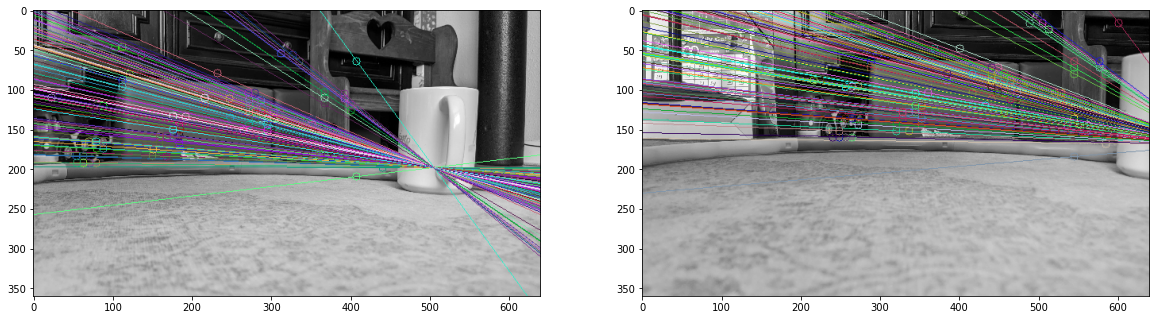

In [45]:
# draw the epipolar lines
img1WEpilines = drawLines(img1_raw, lines1, pts13)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].imshow(img1WEpilines,cmap='gray')
img0WEpilines = drawLines(img0_raw, lines0, pts03)
axes[1].imshow(img0WEpilines,cmap='gray')
plt.show()


## Try pytheia. Had to write my own RANSAC


inliers:  1247  /  1247
score: 0.00406848079139443
F: [[-9.68743927e-08  4.36149854e-06 -7.43195929e-04]
 [ 5.00861236e-07 -5.17844241e-07  6.61454909e-03]
 [ 6.73996050e-05 -7.64657754e-03 -6.32210030e-02]]
(360, 640)
(360, 640)


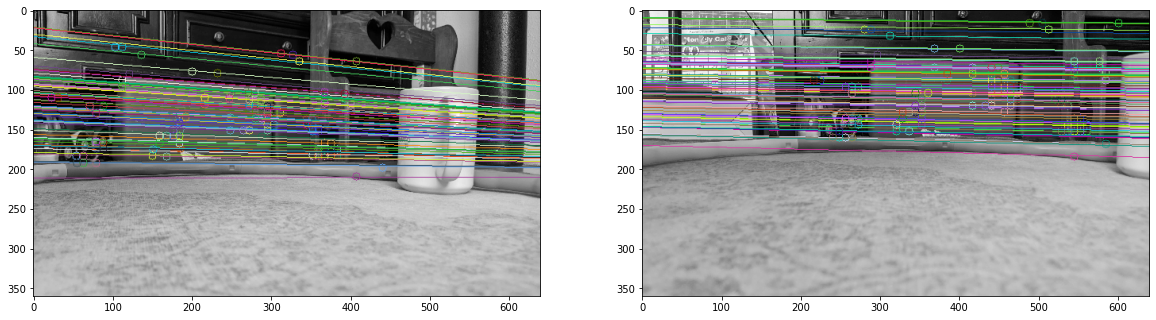

In [46]:
import pytheia as pt
from fundamentalMatrix import ransac_fundamental_matrix

#
# Try pytheia version of fundamental matrix
#

# ret, Fpth = pt.sfm.NormalizedEightPointFundamentalMatrix(mkpts0, mkpts1)
Fpth, mask = ransac_fundamental_matrix(mkpts0, mkpts1)

scorePTH = np.diag((pts13 @ (Fpth @ pts03.T)))
scorePTH = scorePTH.T @ scorePTH
print('score:', scorePTH)
print('F:', Fpth)

lines1pt = (Fpth @ pts03.T).T
lines0pt = (Fpth.T @ pts13.T).T

# draw the epipolar lines
img1WEpilines = drawLines(img1_raw, lines1pt, pts13)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].imshow(img1WEpilines,cmap='gray')
img0WEpilines = drawLines(img0_raw, lines0pt, pts03)
axes[1].imshow(img0WEpilines,cmap='gray')
plt.show()




## Pure python
### EG chat GPTs contribution

inliers:  1247  /  1247
score: 0.0035987735432775215
F: [[ 1.46256430e-07 -8.43054741e-07  2.70932225e-04]
 [ 5.75551126e-06  9.73694303e-08  4.49476907e-03]
 [-1.27263394e-03 -6.53431400e-03  2.13237292e-01]]
mask [ True  True  True ...  True  True  True]
(360, 640)
(360, 640)


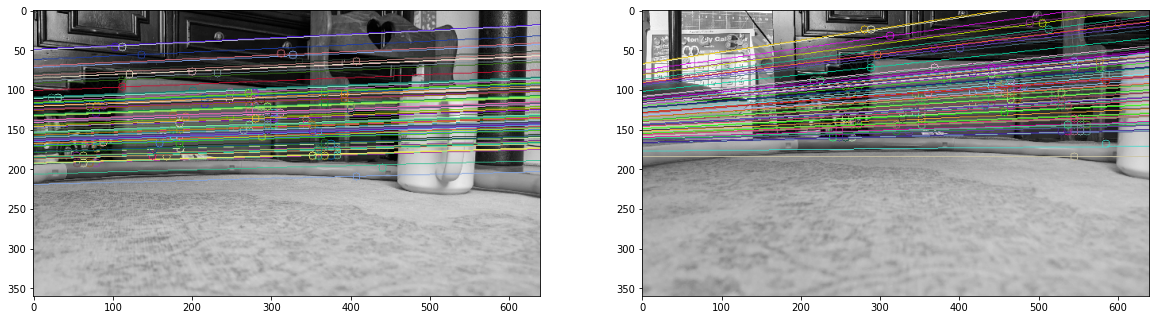

In [47]:
from fundamentalMatrix import ransac_fundamental_matrix, homogenizePoints
from fundamentalMatrix import estimate_normalized_8_point_fundamental_matrix

# Fgpt = estimate_normalized_8_point_fundamental_matrix(mkpts0, mkpts1)
# print('Fgpt:', Fgpt)

Fgpt, mask = ransac_fundamental_matrix(mkpts0, mkpts1, 0.5, 1000, estimate_normalized_8_point_fundamental_matrix)

scoreGPT = np.diag((pts13 @ (Fgpt @ pts03.T)))
scoreGPT = scoreGPT.T @ scoreGPT
print('score:', scoreGPT)
print('F:', Fgpt)
print('mask',mask)

lines1pt = (Fgpt @ pts03.T).T
lines0pt = (Fgpt.T @ pts13.T).T

# draw the epipolar lines
img1WEpilines = drawLines(img1_raw, lines1pt, pts13)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))
axes[0].imshow(img1WEpilines,cmap='gray')
img0WEpilines = drawLines(img0_raw, lines0pt, pts03)
axes[1].imshow(img0WEpilines,cmap='gray')
plt.show()



epipole1 [-784.08600714  185.34336706    1.        ]
epipole2 [-7.70261424e+03  4.16851031e+02  1.00000000e+00]
H2 [[ 9.52379630e-01 -5.15409987e-02  2.45158982e+01]
 [ 2.80745014e-02  9.99943976e-01 -8.97375606e+00]
 [-1.44247479e-04  7.80640295e-06  1.04475404e+00]]
inliers1_hom (3, 102)
a [[ 9.72519444e-01 -1.46582706e-01  4.16220675e-06]
 [ 2.01543755e-01  9.72723254e-01 -3.05258299e-05]
 [-1.93901757e+02  7.53108482e+01  1.02936837e+00]]
H1_pre [[ 9.28193766e-01 -2.19407764e-01  6.24713925e+01]
 [ 2.04736677e-01  9.79162410e-01 -6.17649705e+01]
 [-1.40584287e-04  3.32315139e-05  1.03900530e+00]]
H1 [[ 9.71209424e-01 -2.24778973e-02 -1.53158654e+02]
 [ 5.25074506e-02  9.87118123e-01  9.01092151e+00]
 [-1.47099441e-04  3.40450375e-06  1.07166464e+00]]


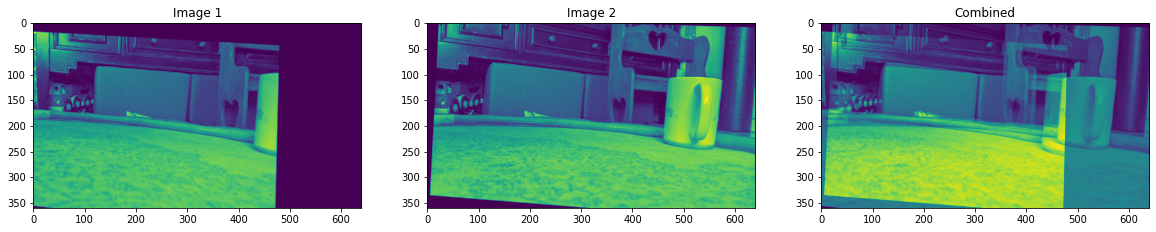

In [48]:
# image rectification

def skewSymmetric(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])

def findEpipole(F):
    U, S, Vt = np.linalg.svd(F)
    e = Vt[-1]
    return e / e[2]
    
# below is from Image Rectification at https://web.stanford.edu/class/cs231a/course_notes/03-epipolar-geometry_2022.pdf
#
# The H1 finding section seems to work, but I could not get the H2 section to work, so I wrote what I thought would work.
def findHomography(F, imgShape, inliers1, inliers2):
    epipole1 = findEpipole(F)
    epipole2 = findEpipole(F.T)
    print('epipole1', epipole1)
    print('epipole2', epipole2)
    T = np.eye(3)
    T[0, 2] = -imgShape[1] / 2
    T[1, 2] = -imgShape[0] / 2

    R0 = np.eye(3)
    alpha = 1
    if epipole2[0] < 0 : 
        alpha = -1 
    denom = np.sqrt(epipole2[0]**2 + epipole2[1]**2)
    R0[0, 0] = alpha * epipole2[0] / denom
    R0[0, 1] = alpha * epipole2[1] / denom
    R0[1, 0] = alpha * -epipole2[1] / denom
    R0[1, 1] = alpha * epipole2[0] / denom

    G = np.eye(3)
    G[2, 0] = -1 / (np.linalg.norm(epipole2 - epipole1))

    H2 = np.linalg.inv(T) @ G @ R0 @ T    
    print('H2', H2)

    # compute H1
    #    The below section is my attempt to do it. It is not what the literature says, but it is my interpretation. 
    # step 1 find a homography such that the epipole is at infinity
    R1 = np.eye(3)
    alpha = 1
    if epipole1[0] < 0 :
        alpha = -1
    denom2 = np.sqrt(epipole1[0]**2 + epipole1[1]**2)
    R1[0, 0] = alpha * epipole1[0] / denom2
    R1[0, 1] = alpha * epipole1[1] / denom2
    R1[1, 0] = alpha * -epipole1[1] / denom2
    R1[1, 1] = alpha * epipole1[0] / denom2
    H1_pre = np.linalg.inv(T) @ G @ R1 @ T
    # step2 fit the points such that it minimizes the error a = minimize(a @ H1_pre @ inliers1 - H2 @ inliers2)
    inliers1_hom = H1_pre @ inliers1.T
    inliers2_hom = H2 @ inliers2.T
    print('inliers1_hom', inliers1_hom.shape)
    phat = inliers1_hom.T
    phat_prime = inliers2_hom.T#[:,0:2]
    a = np.linalg.lstsq(phat, phat_prime, rcond=None)[0]
    print('a', a)
    print('H1_pre', H1_pre)
    H1 = a.T @ H1_pre 



    # # The below section is the way the literature says to do it, but I could not get it to work.
    # ex = skewSymmetric(epipole1)
    # M = ex @ F + epipole1 @ np.array([1,1,1]).T
    # print('m', M)
    # phat = (H2 @ M @ inliers1.T).T
    # phat[:,2] = 1
    # phat_prime = (H2 @ inliers2.T).T
    # phat_prime[:,2] = 1
    # b = phat_prime[:,0]
    # print('inliers', inliers1.shape, 'phat', phat.shape, 'b', b.shape, 'T', T.shape)
    # W = phat
    # # a = np.linalg.inv(W.T @ W) @ W.T @ b
    # a = np.linalg.lstsq(W, b, rcond=None)[0]
    # print(W.shape, b.shape, a.shape)
    
    # Ha = np.eye(3)
    # Ha[0, 0] = a[0]
    # Ha[1, 0] = a[1]
    # Ha[2, 0] = a[2]
    # Ha = Ha.T
    # print('Ha', Ha)

    # H1_bad =  Ha @ H2 @ M 
    # print('H1_bad', H1_bad)
    

    return H1, H2

pts03Inliers = homogenizePoints(mkpts0[mask])
pts13Inliers = homogenizePoints(mkpts1[mask])

H1, H2 = findHomography(Fgpt, img0_raw.shape, pts03, pts13)

print('H1', H1)

# warp image
img0_warped = cv2.warpPerspective(img0_raw, H1, (img0_raw.shape[1], img0_raw.shape[0]))
img1_warped = cv2.warpPerspective(img1_raw, H2, (img0_raw.shape[1], img0_raw.shape[0]))
imgs_combined = 0.5 * img0_warped + 0.5 * img1_warped

fig, (ax1,ax2, ax3) = plt.subplots(nrows=1,ncols=3,figsize=(20,20))

ax1.imshow(img0_warped)
ax1.set_title("Image 1")
ax2.imshow(img1_warped)
ax2.set_title("Image 2")
ax3.imshow(imgs_combined)
ax3.set_title("Combined")

plt.show()

